In [1]:

'''
This script trains a head for the Xception network to predict on CFAIR 10
after training this head the weights for the head are realigned into the dogs and cats dataset
and are trained for 1 epoch the test results of the head transfered and realigned are tested against a random initialization
head's test results and the directly transfered head.

so
1. train head on CIFAR -
2. transfer traditionally to cats and dogs dataset -
3. transfer using IVT - debugging stage
4. use random init head

currently train is using 7,000 samples and test - 3,000 samples
'''

# imports
import torch.nn as nn
from torchvision import transforms, datasets
import numpy as np
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
from torch.utils import data
!pip install pytorchcv --quiet
from pytorchcv.model_provider import get_model
import lightgbm as lgb
import pandas as pd
import torch

In [2]:
i = np.ones([1, 500])/500
print(i.sum())
o = i.dot(np.ones([500, 10])/10)
print(o.sum())


1.0000000000000004
1.0000000000000002


In [3]:
# universal functions:
class Head(torch.nn.Module):
	def __init__(self, in_f, out_f):
		super(Head, self).__init__()
		#self.avgp = nn.AdaptiveAvgPool2d(1)
		self.f = nn.Flatten()
		self.b1 = nn.BatchNorm1d(in_f)
		self.r = nn.ReLU()
		self.o = nn.Linear(in_f, out_f)

	def forward(self, x):
		#x = self.avgp(x)
		x = self.f(x)
		x = self.r(x)
		x = self.b1(x)
		out = self.o(x)
		return out


class FCN(torch.nn.Module):
	def __init__(self, base, in_f):
		super(FCN, self).__init__()
		self.base = base
		self.h1 = Head(in_f, 10)

	def forward(self, x):
		x = self.base(x)
		return self.h1(x)


def test_acc(testloaderc, modelt, width=32):
	if width == 32:
		acc = 0
		total = 0
		for (x, y) in testloaderc:
			x = x.reshape([x.shape[0], 3, width, width]).cuda()
			pred = modelt(x)
			for c, i in enumerate(pred):
				if torch.argmax(i) == y[c]:
					acc += 1
				total += 1
		return acc / total
	else:
		acc = 0
		total = 0
		for (x, y) in testloaderc:
			x = x.reshape([x.shape[0], 3, width, width]).cuda()
			pred = modelt(x)
			for c, i in enumerate(pred):
				if y[c] == 1 and i >= .5:
					acc += 1
				if y[c] == 0 and i <= .4:
					acc += 1
				total += 1
		return acc / total


def train(trainloaderc, modelc, epochs, testloader, optimizerc, width=32):
	modelc = modelc.cuda()
	if width == 32:
		criterion = nn.CrossEntropyLoss()
	else:
		criterion = torch.nn.functional.binary_cross_entropy_with_logits

	total_loss = 0
	t = trainloaderc #tqdm(trainloaderc)
	for _ in range(epochs):

		for i, (x, y) in enumerate(t):
			bs = x.shape[0]
			if width == 32:
				y = y.type(torch.LongTensor).cuda()
			x = x.reshape([x.shape[0], 3, width, width]).cuda()

			pred = modelc(x)

			#print(pred.shape)
			#print(y.shape)
			if width != 32:
				pred = pred.reshape([bs]).cuda()  #.type(torch.LongTensor)
			#print(pred.shape)
			#print(type(pred))
			loss = criterion(pred.cpu(), y.cpu())
			optimizerc.zero_grad()
			loss.backward()
			optimizerc.step()
			total_loss += loss.cpu().detach().numpy()
			#t.set_description(f'loss: %.4f' % (total_loss / (i + 1)))
	return modelc


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

from tqdm import tqdm


In [4]:
# --------------------------------- ivt model ---------------------------------

# --------------------------------- ivt model ---------------------------------

def ivt_realign(model, trainloader, l):

    intermediate = torch.tensor([])
    layers_up_to = []


    layers = [module for module in model.pre.modules() if type(module) != nn.Sequential]
    print(layers)
    for __, layer in enumerate(layers):
        if 'ConvBlock' in str(layer):
            #print(layer)
            layer = list(layer.children())[0]
            #print(layer)
        
        if 'Norm' in str(layer):
            #print('found')
            #layers_up_to.append(layer)
            #print(layer.weight.shape)
            continue
        
        if 'Lin' in str(layer):
            print(str(layer))
            for ii, (X2, Y2) in enumerate(trainloader):
                # could increase compuatational efficiency by looping through data as most outside loop and loop through
                # layers in the innermost, do this for now tho, this could be better/more accurate as to what i am doing

                batch_size = X2.shape[0] # data
                pre = X2.reshape([batch_size, 3, 32, 32]).cuda()

                for up_to in layers_up_to: # get upto this point in calculation
                        #print(pre.shape)
                        pre = up_to(pre)


                #btw indexes needed
                pre = pre.mean(axis=0)/pre.mean(axis=0).sum() # w valuues
                #print(layer.weight.shape)
                w = layer.weight.shape[0] # assume w is 3072
                h = layer.weight.shape[1]
                #print(layer.weight.shape)
                #print(pre.shape)
                
                new = np.array([])
                for i in layer.weight.sum(axis=1): # loop through h times
                    #i = 1/(layer.weight.shape[1]**2) # remove in transfer learning -------------------------------------------------------------------------------------------
                    new = np.append(new, (i * pre).cpu().detach().numpy())

               
                new = new.reshape([w, h]) # this should work
                #print(new[0, 0, :, :])
                intermediate = torch.cat([intermediate.float().cuda(), torch.tensor(new).reshape([1, w, h]).float().cuda()]) # or whatever size
                
                #break
            
            #print(intermediate.mean(axis=0).shape)
            intermediate = intermediate.mean(axis=0)
            layer.weight = torch.nn.Parameter(intermediate, requires_grad=True)
            #x = intermediate.mean(axis=0).cpu().detach().numpy()
            #x = Image.fromarray(x, 'RGB')
            #x.save(str(__) + '2.png')
            intermediate = torch.tensor([])
            layers_up_to.append(layer)
            continue
            
        if 'nv' not in str(layer):
            layers_up_to.append(layer)
            continue

        print("cur layer: ", layer)
        #print(__)

        false_set = False

        for ii, (X2, Y2) in enumerate(trainloader):
            # could increase compuatational efficiency by looping through data as most outside loop and loop through
            # layers in the innermost, do this for now tho, this could be better/more accurate as to what i am doing

            batch_size = X2.shape[0] # data
            pre = X2.reshape([batch_size, 3, l, l]).cuda()

            for up_to in layers_up_to: # get upto this point in calculation
                    pre = up_to(pre)


            #btw indexes needed
            pre = pre.mean(axis=0)
            #print(layer.weight.shape)
            #print(pre.shape)
            k = layer.weight.shape[2] # k size
            features = pre.shape[0] # features in input
            print(pre.shape)
            img_size = pre.shape[2]
            weight_sums_size = layer.weight.shape[0]
            weight_sums = torch.tensor([]).cuda()

            try:
                lwr = layer.weight.reshape([features, weight_sums_size, k * k])
            except:
                false_set = True
                print('identified')
                break

            for _, i in enumerate(lwr):
                #print(i.shape)
                if _ != 0:
                    weight_sums = torch.cat([weight_sums, i.sum(axis=1).reshape([1, weight_sums_size])])
                else:
                    weight_sums = i.sum(axis=1).reshape([1, weight_sums_size])

            #print(weight_sums.shape) # should be 3x64

            imp_vals = torch.tensor([])
            for i in range(features):

                #print(pre.shape)
                try:
                    f = np.array(pre[i, :, :].cpu()).reshape([img_size, img_size])# do 3x3 convolution on this
                except:
                    f = np.array(pre[i, :, :].cpu().detach()).reshape([img_size, img_size])  # do 3x3 convolution on this

                f = np.pad(f, pad_width=1, mode='constant', constant_values=1) # pad with 1s bc vgg16 uses 1 padding for conv                
                view_shape = tuple(np.subtract(f.shape, (k, k)) + 1) + (k, k)
                strides = f.strides + f.strides

                sub_matrices = np.lib.stride_tricks.as_strided(f, view_shape, strides)
                #print(sub_matrices.shape)

                this_imp = torch.tensor(sub_matrices.reshape([k*k, sub_matrices.shape[0]*sub_matrices.shape[1]]).mean(axis=1)).cuda().reshape([1, k, k])# importance for 3x3 conv weight

                #given filter is 1.
                #conv_resultT = torch.tensor(sub_matrices.reshape([9, sub_matrices.shape[0]*sub_matrices.shape[1]])).sum(axis=0) # results in input shape?
                #print(conv_resultT)

                if i != 0:
                    imp_vals = torch.cat([imp_vals, torch.tensor(np.nan_to_num((this_imp/this_imp.sum()).cpu().detach().numpy()).reshape([1, k, k])).cuda()])
                else:
                    imp_vals = torch.tensor(np.nan_to_num((this_imp/this_imp.sum()).cpu().detach().numpy()).reshape([1, k, k])).cuda()
            #print(imp_vals[0]) # should be 3x3x3
            #print(imp_vals.shape)

            # go through in k sizes and find each position's imp_Val/sum_div value
            # sum feature dims together
            # imp vals are overall feature dims in input, one imp val of size kxk
            new = torch.tensor([]).cuda()
            for feature in range(features): # use kernel of given feature dim and sum and redistribute
                for i in weight_sums[feature]:
                    new = torch.cat([new.cuda(), (i * imp_vals[feature]).reshape([1, k, k]).cuda()]) # multiply sum by channel's importancce matrix
            new = new.reshape([weight_sums_size, features, k, k]) # this should work
            #print(new[0, 0, :, :])
            intermediate = torch.cat([intermediate.cuda(), torch.tensor(new).reshape([1, weight_sums_size, features, k, k]).cuda()]) # or whatever size
            #break

        if false_set:
            continue
        
        layer.weight = torch.nn.Parameter(intermediate.mean(axis=0), requires_grad=True)
        intermediate = torch.tensor([])
        layers_up_to.append(layer)
        #x = layer(X2.reshape([batch_size, 3, l, l]).cuda()).mean(axis=0).cpu().detach().numpy()
        #x = x.reshape([x.shape[1], x.shape[1], x.shape[2]])
        #print(x.shape)
        #x = Image.fromarray(x, 'RGB')
        #x.save(str(__) + 'f.png')
        

    return model

In [5]:
class convmodel(torch.nn.Module):
    def __init__(self):
        super(convmodel, self).__init__()
        
        self.pre = get_model("vgg16", pretrained=True)
        self.pre = nn.Sequential(*list(self.pre.children())[:-1])  # Remove original output layer
        self.pre.eval()
        
        #self.conv1 = nn.Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
        #self.b1 = nn.BatchNorm2d([3])#  nn.BatchNorm2d([3, 33, 33])
        
        #self.conv2 = nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1)) #nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #self.b2 = nn.BatchNorm2d([3]) #nn.InstanceNorm2d([32 ,32]) nn.BatchNorm1d
        
        self.f = nn.Flatten()
        
        self.conv3 = nn.Linear(512, 10)#nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.b3 = nn.BatchNorm1d([10])#nn.InstanceNorm1d([32 ,32])
        
        #self.b1.weight = torch.nn.Parameter(torch.ones([3]))
        #self.b2.weight = torch.nn.Parameter(torch.ones([3]))
        self.b3.weight = torch.nn.Parameter(torch.ones([10]))
        
        #self.b1.bias = torch.nn.Parameter(torch.ones([3]))
        #self.b2.bias = torch.nn.Parameter(torch.ones([3]))
        self.b3.bias = torch.nn.Parameter(torch.ones([10]))
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        #x = self.conv1(x)
        #x = self.relu(self.b1(x))
        #x = self.conv2(x)
        #x = self.relu(self.b2(x))
        x = self.pre(x)
        x = self.f(x)
        x = self.conv3(x)
        x = self.relu(self.b3(x))
        return x

In [6]:
# ---------------------------------------- get data ---------------------------------------------

trainset = datasets.CIFAR10(root='CFIAR', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='CFIAR', train=False, download=True, transform=transform)

print(trainset.data.shape)


trainset = data.TensorDataset(torch.Tensor(trainset.data), torch.Tensor(trainset.targets))
testset = data.TensorDataset(torch.Tensor(testset.data), torch.Tensor(testset.targets))

trainloaderl = torch.utils.data.DataLoader(trainset, batch_size=5000, shuffle=True, num_workers=0)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

del trainset
del testset
gc.collect()

Extracting CFIAR/cifar-10-python.tar.gz to CFIAR
Files already downloaded and verified
(50000, 32, 32, 3)



4

In [7]:
# ------------------------------------------- ivt model ----------------------------------
model1 = convmodel().cuda()#
for param in model1.parameters():
    param.requires_grad = True

from PIL import Image

epochs = 30

optimizer = torch.optim.AdamW(model1.parameters(), lr=0.001)
model1 = ivt_realign(model1.cuda(), trainloaderl, 32)

optimizer = torch.optim.AdamW(model1.parameters(), lr=0.001)
acc = []

for skee_yee in range(epochs):
	model1 = train(trainloader, model1, 1, testloader, optimizer)
	acc.append(test_acc(testloader, model1))
	print("accuracy CIFAR: ", acc[skee_yee])

print(np.array(acc).max())
    
del optimizer
gc.collect()


[ConvBlock(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activ): ReLU(inplace=True)
), Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), ConvBlock(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activ): ReLU(inplace=True)
), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), ConvBlock(
  (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activ): ReLU(inplace=True)
), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), ConvBlock(
  (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activ): ReLU(inplace=True)
), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), ConvBlock(
  (c

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
cur layer:  Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([64, 32, 32])
identified
cur layer:  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
cur layer:  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
torch.Size([64, 32, 32])
cur layer:  Con

0

In [8]:
# ------------------------------------------- ivt model ----------------------------------
model2 = convmodel().cuda()#get_model("vgg16", pretrained=True) # convmodel()
for param in model2.parameters():
    param.requires_grad = True
from PIL import Image


optimizer = torch.optim.AdamW(model2.parameters(), lr=0.001)
acc2 = []

for skee_yee in range(31):
	model2 = train(trainloader, model2, 1, testloader, optimizer)
	acc2.append(test_acc(testloader, model2))
	print("accuracy CIFAR: ", acc2[skee_yee])

print(np.array(acc2).max())
    

del optimizer
gc.collect()

accuracy CIFAR:  0.3933
accuracy CIFAR:  0.477
accuracy CIFAR:  0.518
accuracy CIFAR:  0.5531
accuracy CIFAR:  0.5738
accuracy CIFAR:  0.5699
accuracy CIFAR:  0.5843
accuracy CIFAR:  0.5953
accuracy CIFAR:  0.5955
accuracy CIFAR:  0.5976
accuracy CIFAR:  0.5846
accuracy CIFAR:  0.5965
accuracy CIFAR:  0.5906
accuracy CIFAR:  0.5892
accuracy CIFAR:  0.5866
accuracy CIFAR:  0.5825
accuracy CIFAR:  0.5853
accuracy CIFAR:  0.58
accuracy CIFAR:  0.585
accuracy CIFAR:  0.586
accuracy CIFAR:  0.5787
accuracy CIFAR:  0.5834
accuracy CIFAR:  0.5743
accuracy CIFAR:  0.5775
accuracy CIFAR:  0.5836
accuracy CIFAR:  0.5826
accuracy CIFAR:  0.585
accuracy CIFAR:  0.5807
accuracy CIFAR:  0.5781
accuracy CIFAR:  0.5775
accuracy CIFAR:  0.5854
0.5976


0

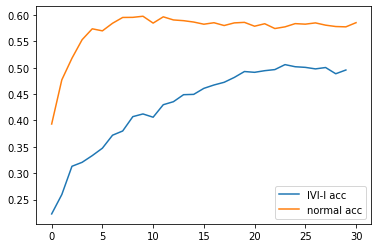

In [9]:
plt.plot(acc, label='IVT-I acc')
plt.plot(acc2, label='normal acc')
plt.legend()
plt.show()